In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
import os
from joblib import Parallel, delayed


# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline

from macd import MACD, DUAL_MACD,  compute_portfolio, run_macd_hyperparam_search, run_macd_hyperparam_search_with_regimes, generate_position
from momentum import SMA, evaluate_momentum_params, run_momentum_hyperparam_search
from performance_metrics import compute_performance_metrics
from supervised_learning import (
    SupervisedLearning,
    create_all_features,
    make_future_log_return,
    make_direction_label
)
from feature_engineering import create_all_features
from regime_clustering import compute_regime_clusters, assign_regimes

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lets_plot import *
LetsPlot.setup_html()

#  <a id = "top"> Table of Contents </a> 

## <font color = blue>[Part 1 - Trading Strategies](#part1)

> Building trading stragies with spy as tradeable Assets
### [1.1 Buy and Hold](#part11)
### [1.2 Baseline MACD](#part12)
### [1.3 Tuned MACD](#part13)
### [1.4 Vol Clustering with MACD](#part14)
### [1.5 SMA (Tuned)](#part15)
### [1.6 Dual MACD](#part16)
### [1.7 SL (Daily Returns)](#part17)


## [Part 2 - Results of Strategies](#part2)

> Visualize results of strategies

## [Part 3 - Executive Summary](#part3)

> Reviewing strategies and backtest results

## [Part 4 - Self-Critique](#part4)

>  dissect and scrutinize our strategies through the lens of common biases and potential market shifts

## [Part 5 - Contribution Statement](#part5)

## <a id = "part1"></a><font color = blue> 👉 Part 1 - Trading strategies</font> [back to table of contents](#top) 

## Exploratory Data Analysis

In [4]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12

In [5]:
spy =\
(
    yf.
    download(
        "^GSPC",
        start = start_date,
        end = end_date
    )
)

spy.columns =\
(
    spy
    .columns
    .droplevel(1) # level 0 --> Price; level 1 --> Ticker
)

spy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000
...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000


In [6]:
df = spy.copy()

## Add Predictions

We transform future returns into predictive labels and train ML models to classify up/down movements, which later act as a filter for momentum trades.

In [7]:
Y_reg = make_future_log_return(spy, price_column="Close", horizon=1)
Y_clf = make_direction_label(Y_reg)   # 1 if up, 0 if down

In [8]:
X = create_all_features(
    spy,
    lagged_return_periods=[1,2,3,5,10],
    vol_periods=[20,60],
    sma_periods=[20,60],
    ema_periods=[10,30],
    rsi_periods=[10,30],
    stok_periods=[14],
    stod_periods=[3],
    roc_periods=[10],
    atr_periods=[5,14]
)


In [9]:
data = pd.concat([Y_clf, X], axis=1).dropna()

Y = data[Y_clf.name]
X = data[X.columns]

SL = SupervisedLearning()

X_train, X_test, Y_train, Y_test = SL.sequential_split(X, Y, train_frac=0.75)

Sequential Split: 3546 train / 1183 test samples


In [10]:
results = SL.run_all_classifiers(X_train, Y_train, X_test, Y_test)
results

Logistic: accuracy=0.5452
RandomForest: accuracy=0.4717
GradientBoosting: accuracy=0.4751
KNN_Classifier: accuracy=0.4827


,Model,Accuracy
0,Logistic,0.545224
1,RandomForest,0.471682
2,GradientBoosting,0.475063
3,KNN_Classifier,0.482671


In [11]:
result = SL.tune_probability_threshold(
    model = SL.get_classifier_by_name('Logistic'),
    X_train = X_train,
    y_train = Y_train,
    X_test  = X_test,
    y_test  = Y_test,
    thresholds = np.arange(0.50, 0.80, 0.01),
    return_metric="sharpe"
)

result["best_threshold"]
result["threshold_cv_results"].head()


Best Threshold = 0.500
threshold          0.500000
train_sharpe      16.070455
test_sharpe       15.881216
train_accuracy     0.555556
test_accuracy      0.545224
Name: 0, dtype: float64


,threshold,train_sharpe,test_sharpe,train_accuracy,test_accuracy
0,0.50,16.070455,15.881216,0.555556,0.545224
1,0.51,15.248894,15.275259,0.556402,0.542688
2,0.52,14.107627,14.541461,0.549069,0.535926
3,0.53,12.676720,13.789407,0.543711,0.524937
4,0.54,11.010402,12.589440,0.534969,0.508876


In [12]:
result

{'threshold_cv_results':     threshold  train_sharpe  test_sharpe  train_accuracy  test_accuracy
 0        0.50     16.070455    15.881216        0.555556       0.545224
 1        0.51     15.248894    15.275259        0.556402       0.542688
 2        0.52     14.107627    14.541461        0.549069       0.535926
 3        0.53     12.676720    13.789407        0.543711       0.524937
 4        0.54     11.010402    12.589440        0.534969       0.508876
 5        0.55      9.518897    11.664337        0.530457       0.505495
 6        0.56      8.060439    10.431835        0.515510       0.492815
 7        0.57      6.601928     9.001220        0.500846       0.481826
 8        0.58      5.376549     7.795323        0.487592       0.479290
 9        0.59      4.593119     6.343228        0.483362       0.470837
 10       0.60      3.797590     5.306636        0.474619       0.471682
 11       0.61      3.253689     4.414941        0.470107       0.475909
 12       0.62      2.67589

In [13]:
result['model']

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [14]:
clf = result["model"]
best_th = result["best_threshold"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Probability SPY goes UP
p_train = clf.predict_proba(X_train_scaled)[:, 1]
p_test  = clf.predict_proba(X_test_scaled)[:, 1]
train_pred = (p_train > best_th).astype(int)
test_pred  = (p_test > best_th).astype(int)

In [15]:
df.loc[X_train.index, "ml_prob"] = p_train
df.loc[X_train.index, "ml_signal"] = train_pred

df.loc[X_test.index, "ml_prob"] = p_test
df.loc[X_test.index, "ml_signal"] = test_pred

# df = df.bfill() # just to complet the ml prob and ml signal accoridng

In [16]:
df

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal
Date,,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN,NaN
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,NaN,NaN
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,NaN,NaN
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,NaN,NaN
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,NaN,NaN
...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0


### Passive Returns

In [17]:
split_idx = int(len(df) * 0.75)

df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

In [18]:
def generate_passive_returns(df: pd.DataFrame):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df['Close']
            /
            df['Close'].shift(1)
            )
    )

    df['cumulative_passive_returns'] =\
    (
        np.exp(
            df['passive_returns']
            .fillna(0)
            .cumsum()
        )
    )
    return df

In [19]:
df_train = generate_passive_returns(df_train)
df_test = generate_passive_returns(df_test)

In [20]:
def plot_returns(df, y,
                date_column = 'Date',
                returns_column = 'cumulative_passive_returns'):
    
    melted = (
        df[[date_column, returns_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={returns_column: "blue"})
        + labs(
            title="Cumulative Returns",
            x="Date",
            y=y,
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [21]:
plot_returns(
    df=df_train.reset_index(),
    y='Training Returns'
)

In [22]:
plot_returns(
    df=df_test.reset_index(),
    y='Testing Returns'
)

In [23]:
(
    df_test['ml_signal']
    .value_counts()
)

ml_signal
1.0    1099
0.0      98
Name: count, dtype: int64

<Axes: xlabel='Date'>

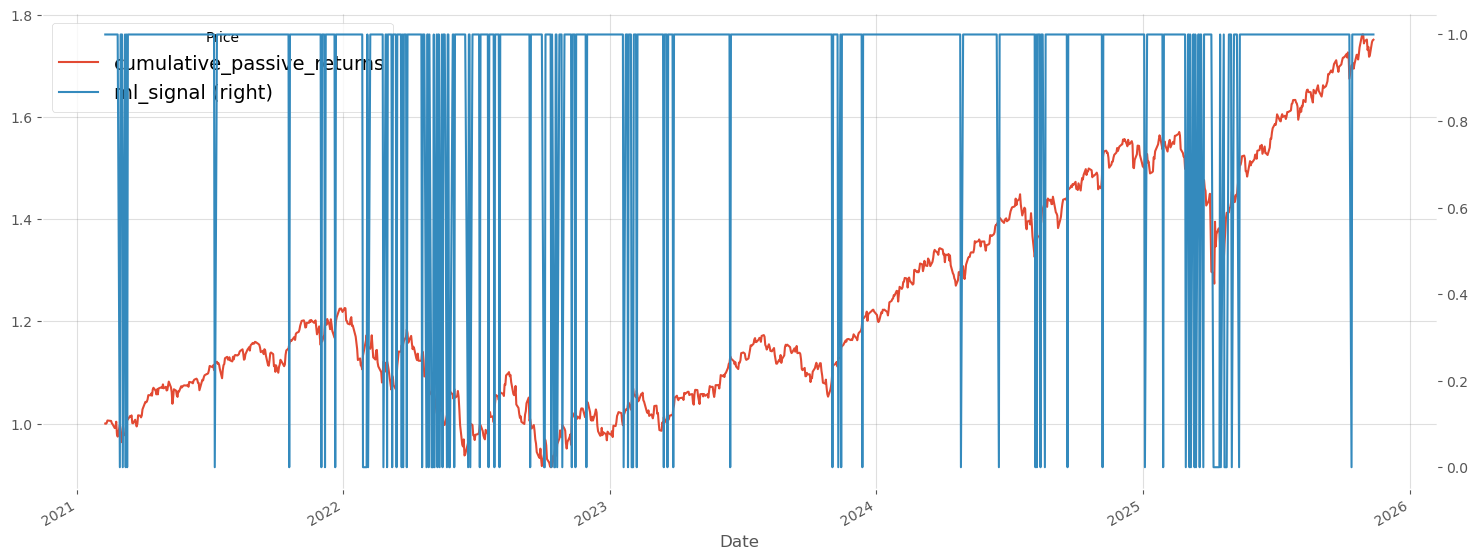

In [24]:
(
    df_test[['cumulative_passive_returns','ml_signal']]
    .plot(secondary_y = "ml_signal",
          figsize = [18, 7]
         )
)

# Individual Strategies

In [25]:
starting_capital = 100_000.0

In [26]:
combined_results = []

In [27]:
df_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns
Date,,,,,,,,,
2021-02-09,3911.229980,3918.350098,3902.639893,3910.489990,4568320000,0.572003,1.0,NaN,1.000000
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,0.547191,1.0,-0.000345,0.999655
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,0.549588,1.0,0.001661,1.001317
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,0.526929,1.0,0.004700,1.006034
2021-02-16,3932.590088,3950.429932,3923.850098,3939.610107,5058990000,0.551681,1.0,-0.000569,1.005461
...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875


## <a id = "part11"></a> 1.1 Buy and Hold [back to table of contents](#top) 

In [28]:
buy_and_hold = \
(
    compute_performance_metrics(
        log_returns=df_test['passive_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Buy and Hold'
    )
)
print(buy_and_hold)

               CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Buy and Hold  0.125       0.171         0.254         0.776          1.273   

              Calmar Ratio  Final Portfolio Value  Cumulative Return  
Buy and Hold         0.492             175160.243              1.752  


In [29]:
combined_results.append(buy_and_hold)

## <a id = "part12"></a> 1.2 Baseline MACD [back to table of contents](#top) 

In [30]:
baseline_macd = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=False)
baseline_macd = compute_portfolio(
    df = baseline_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,12_ewma,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211,6785.927672,...,NaN,0.0,116013.384033,0.0,-1.0,0.0,0.0,116013.384033,-0.011071,1.160134
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379,6777.138769,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875,6785.645139,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.585629,1.0,0.002073,1.750500,6795.024328,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.585140,1.0,0.000629,1.751602,6803.623650,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134


In [31]:
baseline_macd_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Base)'
    )
)

In [32]:
combined_results.append(baseline_macd_metric)

## <a id = "part13"></a> 1.3 Tuned MACD [back to table of contents](#top) 

In [33]:
results = []
short_choices = np.linspace(6, 20, 10).astype(int).tolist()
long_choices = np.linspace(20, 60, 10).astype(int).tolist()
signal_choices = np.linspace(5, 20, 10).astype(int).tolist()
allow_short = True

# ---- CREATE TASK LIST ----
macd_task_list = [
    (short_ma, long_ma, signal)
    for short_ma in short_choices
    for long_ma in long_choices
    if long_ma > short_ma
    for signal in signal_choices
]

In [34]:
df_train

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns
Date,,,,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN,NaN,NaN,1.000000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,NaN,NaN,-0.000344,0.999656
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,NaN,NaN,-0.002226,0.997434
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,NaN,NaN,0.011283,1.008751
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,NaN,NaN,0.002215,1.010988
...,...,...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.506295,1.0,0.013803,2.797399
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.568662,1.0,0.001008,2.800221
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.524236,1.0,0.010795,2.830612


In [35]:
macd_hyperparam_df =\
(
    run_macd_hyperparam_search(
        df = df_train,
        price_col='Close',
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=allow_short,
        cache_file="data/hyperparams_macd.csv"
    )
)
macd_hyperparam_df

Loaded cached results from: data/hyperparams_macd.csv


,short_ma,long_ma,signal,regime,cumulative_return,sharpe
0,9,46,6,NaN,1.751703,0.207123
1,6,55,8,NaN,1.730799,0.203538
2,7,46,8,NaN,1.704261,0.197003
3,7,55,8,NaN,1.698361,0.195944
4,6,46,10,NaN,1.697069,0.195694
...,...,...,...,...,...,...
985,20,42,11,NaN,0.276656,-0.487218
986,20,24,20,NaN,0.275982,-0.488386
987,16,46,13,NaN,0.275491,-0.488653
988,15,42,15,NaN,0.270720,-0.493638


In [36]:
best_row =\
(
    pd.DataFrame(macd_hyperparam_df)
        .sort_values("cumulative_return", ascending=False)
).iloc[0]

best_row

short_ma              9.000000
long_ma              46.000000
signal                6.000000
regime                     NaN
cumulative_return     1.751703
sharpe                0.207123
Name: 0, dtype: float64

In [37]:
best_span_list = [best_row['short_ma'],best_row['long_ma'],best_row['signal']]
best_span_list


[9.0, 46.0, 6.0]

In [38]:
best_span_macd = MACD(df_test, span=best_span_list, price_col='Close', allow_short=allow_short)
best_span_macd = compute_portfolio(
    df = best_span_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

best_span_macd.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,9.0_ewma,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211,6790.048214,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-67203.198242,73508.975586,0.010389,0.735090
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379,6777.798532,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-67287.998047,73424.175781,-0.001154,0.734242
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875,6788.724861,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68324.301758,72387.872070,-0.014214,0.723879
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.585629,1.0,0.002073,1.750500,6800.301861,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68466.098633,72246.075195,-0.001961,0.722461
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.585140,1.0,0.000629,1.751602,6810.425474,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68509.199219,72202.974609,-0.000597,0.722030


In [39]:
best_span_macd_metric = \
(
    compute_performance_metrics(
        log_returns=best_span_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Tuned)'
    )
)
best_span_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Tuned),-0.066,0.163,0.373,-0.338,-0.539,-0.177,72202.975,0.722


In [40]:
combined_results.append(best_span_macd_metric)

## <a id = "part14"></a> 1.4 Vol Clustering with MACD [back to table of contents](#top) 


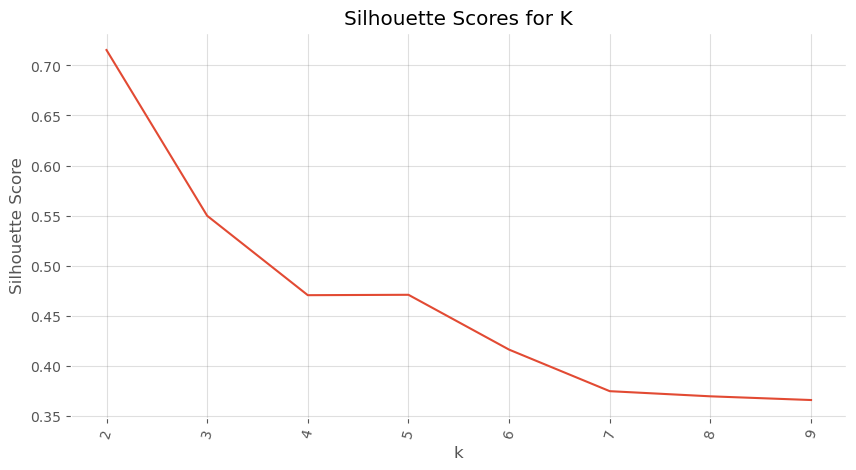

In [41]:
scaler, kmeans, train_regimes, train_feat = compute_regime_clusters(
    df_train,
    n_clusters=None,      # auto choose using silhouette
    atr_window=14,
    vol_windows=[20, 60]
)

In [42]:
df_train_macd =\
(
    assign_regimes(
        df_train,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)
df_train_macd

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,,,
2007-01-31,1438.239990,1441.609985,1424.780029,1428.650024,2976690000,0.551865,1.0,0.006571,1.051491,0.0
2007-02-01,1445.939941,1446.640015,1437.900024,1437.900024,2914890000,0.536530,1.0,0.005339,1.057120,0.0
2007-02-02,1448.390015,1449.329956,1444.489990,1445.939941,2569450000,0.538969,1.0,0.001693,1.058912,0.0
2007-02-05,1446.989990,1449.380005,1443.849976,1448.329956,2439430000,0.532291,1.0,-0.000967,1.057888,0.0
2007-02-06,1448.000000,1450.189941,1443.400024,1446.979980,2608710000,0.529898,1.0,0.000698,1.058627,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.506295,1.0,0.013803,2.797399,0.0
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.568662,1.0,0.001008,2.800221,0.0
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.524236,1.0,0.010795,2.830612,0.0


In [43]:
regimes = sorted(df_train_macd["regime"].unique())

regime_dfs = { r: df_train_macd[df_train_macd["regime"] == r].copy()
               for r in regimes }

In [44]:
regimes

[0.0, 1.0]

In [45]:
macd_vol_clustering_hyperparam_df =\
(
    run_macd_hyperparam_search_with_regimes(
        df = df_train_macd,
        price_col='Close',
        regimes = regimes,
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file="data/vol_clustering_with_macd.csv"
    )
)
macd_vol_clustering_hyperparam_df

,short_ma,long_ma,signal,regime,cumulative_return,sharpe
50,6,42,5,0.0,1.748667,0.451060
40,6,37,5,0.0,1.745270,0.448945
130,7,33,5,0.0,1.739293,0.444462
581,13,55,6,0.0,1.719698,0.429352
261,9,46,6,0.0,1.713653,0.429498
...,...,...,...,...,...,...
1776,16,55,15,1.0,0.825558,-0.168664
1865,18,51,13,1.0,0.825558,-0.168664
1489,12,60,20,1.0,0.818578,-0.175740
1659,15,46,20,1.0,0.804439,-0.193186


In [46]:
best_per_regime = (
    macd_vol_clustering_hyperparam_df
    .sort_values("cumulative_return", ascending=False)
    .groupby("regime")
    .head(1)
    .reset_index(drop=True)
)

print(best_per_regime)


   short_ma  long_ma  signal  regime  cumulative_return    sharpe
0         6       42       5     0.0           1.748667  0.451060
1        12       42       5     1.0           1.499613  0.356207


In [47]:
regime_macd_lookup = {
    row.regime: (row.short_ma, row.long_ma, row.signal)
    for _, row in best_per_regime.iterrows()
}

print(regime_macd_lookup)


{0.0: (6.0, 42.0, 5.0), 1.0: (12.0, 42.0, 5.0)}


In [48]:
vol_clustering_macd_test =\
(
    assign_regimes(
        df_test,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)

vol_clustering_macd_test.head()

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.540783,1.0,0.008132,1.074245,0.0
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.557674,1.0,0.007346,1.082166,0.0
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,0.604839,1.0,-0.010490,1.070873,0.0
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,0.577424,1.0,-0.008712,1.061584,0.0
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,0.600687,1.0,-0.021683,1.038814,0.0


In [49]:
for r in regimes:
    df_r = vol_clustering_macd_test[vol_clustering_macd_test["regime"] == r].copy()
    spans = regime_macd_lookup[r]
    df_r = MACD(df_r, spans, price_col='Close', allow_short=False)
    vol_clustering_macd_test.loc[df_r.index, f"signal_r{r}"] = df_r["signal"]

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime,signal_r0.0,signal_r1.0
Date,,,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.540783,1.0,0.008132,1.074245,0.0,NaN,NaN
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.557674,1.0,0.007346,1.082166,0.0,NaN,NaN
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,0.604839,1.0,-0.010490,1.070873,0.0,0.0,NaN
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,0.577424,1.0,-0.008712,1.061584,0.0,NaN,NaN
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,0.600687,1.0,-0.021683,1.038814,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211,0.0,NaN,NaN
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379,0.0,NaN,NaN
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875,0.0,NaN,NaN


In [50]:
signal_cols = [col for col in vol_clustering_macd_test.columns if col.startswith("signal_r")]
signal_cols

['signal_r0.0', 'signal_r1.0']

In [51]:
vol_clustering_macd_test["signal"] =\
(
    vol_clustering_macd_test[signal_cols]
    .bfill(axis=1)
    .iloc[:, 0]
)

In [52]:
vol_clustering_macd_test = generate_position(vol_clustering_macd_test)

In [53]:
positions_df = vol_clustering_macd_test[['positions']].reset_index()

plot = (
    ggplot(positions_df, aes(x='Date', y='positions'))
    + geom_line(color='blue', size=1)
    + labs(
        title='Trading Positions Over Time',
        x='Date',
        y='Position',
        caption='1 = Long, 0 = No Position, -1 = Short'
    )
    + theme(legend_position='top')
    + ggsize(1200, 500)
)

plot.show()

In [54]:
vol_clustering_macd_test = compute_portfolio(
    vol_clustering_macd_test,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,regime,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.540783,1.0,0.008132,1.074245,0.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.557674,1.0,0.007346,1.082166,0.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,0.604839,1.0,-0.010490,1.070873,0.0,...,0.0,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,0.577424,1.0,-0.008712,1.061584,0.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,0.600687,1.0,-0.021683,1.038814,0.0,...,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211,0.0,...,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379,0.0,...,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875,0.0,...,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012


In [55]:
def plot_cumulative_returns(df,
                               date_column = 'Date',
                               strategy_column = 'cumulative_returns_strategy',
                               passive_column = 'cumulative_returns_passive'):
    
    melted = (
        df[[date_column, strategy_column, passive_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={strategy_column: "blue", passive_column: "red"})
        + labs(
            title="Cumulative Returns Comparison",
            x="Date",
            y="Cumulative Return",
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [56]:
(
    plot_cumulative_returns(
        df = vol_clustering_macd_test.reset_index(),
        date_column='Date',
        strategy_column = 'cumulative_strategy_returns',
        passive_column='cumulative_passive_returns'
    )  
)

In [57]:
vol_clustering_macd_metric = \
(
    compute_performance_metrics(
        log_returns=vol_clustering_macd_test['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Hyperparams)'
    )
)
vol_clustering_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Hyperparams),0.002,0.107,0.192,0.072,0.105,0.01,100901.15,1.009


In [58]:
combined_results.append(vol_clustering_macd_metric)

## <a id = "part15"></a> 1.5 SMA (Tuned) [back to table of contents](#top) 


In [59]:
# original, overfitting suspected, removing it for now
# short_windows = np.arange(1,301)
# long_windows  = np.arange(1,301)
# momentum_tasks = [
#     (s, l)
#     for s in short_windows
#     for l in long_windows
#     if l > s
# ]

short_windows = range(3, 10)
ratio_values = np.arange(1.5,6.5,0.5)

momentum_tasks = [
    (s, int(s * r))
    for s in short_windows
    for r in ratio_values
]

len(momentum_tasks)

70

In [60]:
momentum_hyperparam_df =\
(
    run_momentum_hyperparam_search(
        df = df_train,
        price_col='Close',
        momentum_task_list=momentum_tasks,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file = "data/hyperparams_momentum_basic.csv"
    )
)

momentum_hyperparam_df

Loaded cached Momentum results from: data/hyperparams_momentum_basic.csv


,short_window,long_window,regime,cumulative_return,sharpe
0,9,27,NaN,2.177947,0.465420
1,6,27,NaN,2.140740,0.463192
2,8,24,NaN,2.080049,0.433444
3,8,28,NaN,2.049542,0.435932
4,7,24,NaN,2.019483,0.416512
...,...,...,...,...,...
65,3,9,NaN,1.003771,0.002150
66,4,10,NaN,0.997669,-0.001332
67,4,8,NaN,0.993139,-0.003883
68,5,7,NaN,0.883460,-0.070324


In [61]:
best_momentum = momentum_hyperparam_df.iloc[0]
best_short, best_long = best_momentum['short_window'], best_momentum['long_window']
best_short, best_long

(9.0, 27.0)

In [62]:
best_momentum_df=\
(
    SMA(
        df=df_test,
        windows=[int(best_short),int(best_long)]
    )
)
best_momentum_df =\
(
    compute_portfolio(
        best_momentum_df,
        price_column='Close',
        position_column='positions',
        initial_capital=starting_capital
    )
)

In [63]:
momentum_hyperparam_metrics =\
(
    compute_performance_metrics(
        best_momentum_df['strategy_returns'],
        initial_capital=starting_capital,
        strategy='SMA'
    )
)
momentum_hyperparam_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
SMA,0.101,0.109,0.146,0.935,1.469,0.689,157687.014,1.577


In [64]:
combined_results.append(momentum_hyperparam_metrics)

## <a id = "part16"></a> 1.6 Dual MACD [back to table of contents](#top) 

In [65]:
fast_spans = [3, 10, 16]   
slow_spans = [12, 26, 9]

dual_macd =\
(
    DUAL_MACD(
        df=df_test,
        fast_spans=fast_spans,
        slow_spans=slow_spans,
        price_column="Close",
        allow_short=False,
    )
)

dual_macd.head(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,fast_ewma_short,fast_ewma_long,fast_macd,fast_signal,slow_ewma_short,slow_ewma_long,slow_macd,slow_signal,fast_cross_up,fast_cross_down,dual_macd_signal
Date,,,,,,,,,,,,,,,,,,,,
2021-02-09,3911.229980,3918.350098,3902.639893,3910.489990,4568320000,0.572003,1.0,NaN,1.000000,3911.229980,3911.229980,0.000000,0.000000,3911.229980,3911.229980,0.000000,0.000000,False,False,NaN
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,0.547191,1.0,-0.000345,0.999655,3910.329915,3910.487427,-0.157511,-0.083678,3910.498678,3910.528968,-0.030291,-0.016828,False,True,0.0
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,0.549588,1.0,0.001661,1.001317,3913.787040,3912.856155,0.930885,0.297608,3912.794113,3912.631145,0.162968,0.056859,True,False,1.0
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,0.526929,1.0,0.004700,1.006034,3925.009993,3920.095584,4.914410,1.676642,3919.750006,3918.836997,0.913010,0.346883,False,False,NaN
2021-02-16,3932.590088,3950.429932,3923.850098,3939.610107,5058990000,0.551681,1.0,-0.000569,1.005461,3928.922300,3923.682416,5.239884,2.577819,3923.238611,3922.026395,1.212215,0.604300,False,False,NaN


In [66]:
dual_macd = generate_position(
    dual_macd,
    signal_column='dual_macd_signal'
)
dual_macd = compute_portfolio(
    dual_macd,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)
dual_macd.tail(5)

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns,fast_ewma_short,...,dual_macd_signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211,6761.655676,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379,6745.227740,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875,6788.828958,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.585629,1.0,0.002073,1.750500,6817.719411,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.585140,1.0,0.000629,1.751602,6834.319666,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677


In [67]:
dual_macd_metrics = \
(
    compute_performance_metrics(
        log_returns=dual_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Dual MACD'
    )
)
print(dual_macd_metrics)


            CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Dual MACD  0.055       0.098         0.118         0.594          0.909   

           Calmar Ratio  Final Portfolio Value  Cumulative Return  
Dual MACD         0.467             128967.673               1.29  


In [68]:
(
    plot_cumulative_returns(
        df =dual_macd.reset_index(),
        passive_column='cumulative_passive_returns',
        strategy_column='cumulative_strategy_returns'
    )
)

In [69]:
combined_results.append(dual_macd_metrics)

## <a id = "part17"></a> 1.7 SL (Daily Returns) [back to table of contents](#top) 

In [70]:
return_period = 1
Y =\
(
    np
    .log(spy['Close']
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name = 'SPY_pred'

Y

Date
2006-11-01   -0.000344
2006-11-02   -0.002226
2006-11-03    0.011283
2006-11-06    0.002215
2006-11-07    0.002081
                ...   
2025-11-06    0.001261
2025-11-07    0.015284
2025-11-10    0.002073
2025-11-11    0.000629
2025-11-12         NaN
Name: SPY_pred, Length: 4788, dtype: float64

In [71]:
lag_periods = [i for i in range(1,11)]
vol_periods = [5,10,20,60,120]
sma_periods = [63]
ema_periods = [10,30]
rsi_periods = [10,30]
stok_periods = [30]
stod_periods = [30]
roc_periods = [30]
atr_periods = [5, 14, 21]


X = create_all_features(
    spy,
    price_column='Close',
    lagged_return_periods=lag_periods,
    vol_periods=vol_periods,
    sma_periods=sma_periods,
    ema_periods=ema_periods,
    rsi_periods=rsi_periods,
    stok_periods=stok_periods,
    stod_periods=stod_periods,
    roc_periods=roc_periods,
    atr_periods=atr_periods
)

X

,1DT,2DT,3DT,4DT,5DT,6DT,7DT,8DT,9DT,10DT,...,EMA10,EMA30,RSI10,RSI30,%K30,%D30,ROC30,ATR5,ATR14,ATR21
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1367.810059,1367.810059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,-0.000344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1367.724587,1367.779730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,-0.002226,-0.002569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1367.101944,1367.555234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,0.011283,0.009057,0.008713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1369.407050,1368.343931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,0.002215,0.013498,0.011272,0.010928,NaN,NaN,NaN,NaN,NaN,NaN,...,1371.849399,1369.279159,NaN,NaN,NaN,NaN,NaN,11.740015,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,-0.011241,-0.007594,-0.019400,-0.017681,-0.015067,-0.025021,-0.025065,-0.022779,-0.010564,-0.002693,...,6789.225371,6731.548794,47.876348,54.873023,45.876180,57.349299,1.153267,73.542090,67.680734,83.421015
2025-11-07,0.001261,-0.009980,-0.006333,-0.018139,-0.016420,-0.013806,-0.023760,-0.023803,-0.021518,-0.009303,...,6778.238905,6731.371440,41.808905,53.669848,48.170795,53.493363,1.014678,80.294043,68.989990,85.814337
2025-11-10,0.015284,0.016545,0.005304,0.008950,-0.002856,-0.001137,0.001478,-0.008476,-0.008520,-0.006235,...,6788.091863,6737.891358,44.792050,56.820149,76.212346,56.753107,2.152517,90.458105,74.874965,81.095285


In [72]:
data =\
(
    pd
    .concat([Y, X],
            axis = 1)
    .dropna()
)

Y =\
(
    data
    .loc[ : , Y.name]
)
X =\
(
    data
    .loc[ : , X.columns]
)

In [73]:
SL =\
(
    SupervisedLearning()
)

In [74]:
X_train, X_test, Y_train, Y_test =\
(
    SL
    .sequential_split(X,Y,train_frac=0.75)
    
)

Sequential Split: 3501 train / 1167 test samples


In [75]:
seed = 2025
num_folds = 10

metric = "neg_mean_squared_error"

In [76]:
results =\
(
    SL
    .run_all_models(
        X_train = X_train,
        Y_train = Y_train,
        X_test = X_test,
        Y_test = Y_test,
        num_folds = num_folds,
        seed = seed,
        metric = metric
    )
)

LR: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
LASSO: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
Elastic Net Penalty: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
Decision Tree: CV_Mean=0.0004, CV_Std=0.0001, Train_MSE=0.0000, Test_MSE=0.0005
Random Forest: CV_Mean=0.0002, CV_Std=0.0001, Train_MSE=0.0000, Test_MSE=0.0002
Extra Trees: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0000, Test_MSE=0.0002
Gradient Boosting: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0002
Adaptive Boosting: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0001
Support Vector Machine: CV_Mean=0.0002, CV_Std=0.0001, Train_MSE=0.0002, Test_MSE=0.0002
K-Nearest Neighbors: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0001


In [77]:
(
    SL
    .plot_performance(results['comparison_df'])
)

In [78]:
# chosen model is K-Nearest Neighbors
model =\
(
    SL.get_model_by_name("K-Nearest Neighbors")
)

model

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [79]:
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [80]:
testing_df =\
(
    spy
    .copy()
    .rename(columns={'Close': "actual_close"})
)

testing_df

Price,actual_close,High,Low,Open,Volume
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000
...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000


In [81]:
testing_df.loc[X_test.index, "pred_return"] = y_pred
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return
Date,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,NaN
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,NaN
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,NaN
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,NaN
...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.002652
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,-0.002652
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,-0.002652


In [82]:
testing_df["pred_close"] =\
(
    testing_df["actual_close"] 
    * np.exp(testing_df["pred_return"])
)

In [83]:
def generate_signal_simple(df: pd.DataFrame):
    df = df.copy()
    df['signal'] = (df['pred_return'] > 0).astype(int)

    df['positions'] = df['signal'] 
    # no need to shift(1) cause we using predicted returns
    return df

In [84]:
def compute_cumulative_returns(df, 
                       position_column = 'positions',
                       price_column = 'Close'):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df[price_column]
            /
            df[price_column].shift(1)
            )
    )

    df['strategy_returns'] =\
    (
        df[position_column].shift(1)
        *
        df['passive_returns']
    )

    df['cum_log_returns'] =\
    (
        df['strategy_returns']
        .cumsum()
    )

    df['cumulative_returns_strategy'] =\
    (
        np.exp(
            df['cum_log_returns']
        )
    )

    df['cumulative_max_strategy'] =\
    (
        df['cumulative_returns_strategy']
        .cummax()
    )

    df['cumulative_returns_passive'] =\
    (
        np.exp(
            df['passive_returns']
            .cumsum()
        )
    )
    return df

In [85]:
testing_df =\
(
    generate_signal_simple(testing_df)
    .dropna()
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close,signal,positions
Date,,,,,,,,,
2021-03-23,3910.520020,3949.129883,3901.570068,3937.600098,4669010000,-0.002652,3900.164805,0,0
2021-03-24,3889.139893,3942.080078,3889.070068,3919.929932,4783020000,-0.002652,3878.841294,0,0
2021-03-25,3909.520020,3919.540039,3853.500000,3879.340088,4948340000,-0.002652,3899.167453,0,0
2021-03-26,3974.540039,3978.189941,3917.120117,3917.120117,5483160000,-0.002652,3964.015297,0,0
2021-03-29,3971.090088,3981.830078,3943.250000,3969.310059,4628180000,-0.002652,3960.574482,0,0
...,...,...,...,...,...,...,...,...,...
2025-11-05,6796.290039,6829.779785,6763.109863,6769.770020,5939600000,-0.002652,6778.293190,0,0
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.002652,6702.524147,0,0
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,-0.002652,6710.981672,0,0


In [86]:
testing_df =\
(
    compute_cumulative_returns(
        df = testing_df,
        position_column='positions',
        price_column = 'actual_close'
    )
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close,signal,positions,passive_returns,strategy_returns,cum_log_returns,cumulative_returns_strategy,cumulative_max_strategy,cumulative_returns_passive
Date,,,,,,,,,,,,,,,
2021-03-23,3910.520020,3949.129883,3901.570068,3937.600098,4669010000,-0.002652,3900.164805,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-24,3889.139893,3942.080078,3889.070068,3919.929932,4783020000,-0.002652,3878.841294,0,0,-0.005482,-0.0,0.000000,1.000000,1.000000,0.994533
2021-03-25,3909.520020,3919.540039,3853.500000,3879.340088,4948340000,-0.002652,3899.167453,0,0,0.005227,0.0,0.000000,1.000000,1.000000,0.999744
2021-03-26,3974.540039,3978.189941,3917.120117,3917.120117,5483160000,-0.002652,3964.015297,0,0,0.016494,0.0,0.000000,1.000000,1.000000,1.016371
2021-03-29,3971.090088,3981.830078,3943.250000,3969.310059,4628180000,-0.002652,3960.574482,0,0,-0.000868,-0.0,0.000000,1.000000,1.000000,1.015489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,6796.290039,6829.779785,6763.109863,6769.770020,5939600000,-0.002652,6778.293190,0,0,0.003647,0.0,0.157973,1.171134,1.171134,1.737950
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.002652,6702.524147,0,0,-0.011241,-0.0,0.157973,1.171134,1.171134,1.718523
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,-0.002652,6710.981672,0,0,0.001261,0.0,0.157973,1.171134,1.171134,1.720692


In [87]:
ml_pred_returns_metrics =\
(
    compute_performance_metrics(
        log_returns=testing_df['strategy_returns'],
        initial_capital=100_000,
        strategy='ML (Predict Returns)'
    )
)

ml_pred_returns_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
ML (Predict Returns),0.035,0.058,0.056,0.613,1.151,0.614,117113.447,1.171


In [88]:
combined_results.append(ml_pred_returns_metrics)

## 👇 <a id = "part2"></a><font color = blue> 👉 Part 2 - Results of Strategies </font> [back to table of contents](#top)

In [89]:
comparison_df=\
(
    pd.concat(
        combined_results,
        axis=0
    )
    .sort_values(by='Final Portfolio Value', ascending=False)
)

comparison_df

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
Buy and Hold,0.125,0.171,0.254,0.776,1.273,0.492,175160.243,1.752
SMA,0.101,0.109,0.146,0.935,1.469,0.689,157687.014,1.577
Dual MACD,0.055,0.098,0.118,0.594,0.909,0.467,128967.673,1.290
ML (Predict Returns),0.035,0.058,0.056,0.613,1.151,0.614,117113.447,1.171
MACD (Base),0.032,0.105,0.174,0.350,0.520,0.183,116013.384,1.160
MACD (Hyperparams),0.002,0.107,0.192,0.072,0.105,0.010,100901.150,1.009
MACD (Tuned),-0.066,0.163,0.373,-0.338,-0.539,-0.177,72202.975,0.722


In [90]:
comparison_df.index

Index(['Buy and Hold', 'SMA', 'Dual MACD', 'ML (Predict Returns)',
       'MACD (Base)', 'MACD (Hyperparams)', 'MACD (Tuned)'],
      dtype='object')

## 👇 <a id = "part3"></a><font color = blue> Part 3 - Executive Summary</font> [back to table of contents](#top)

write summary hereeee

## 👇 <a id = "part4"></a><font color = blue> Part 4 - Self-Critique</font> [back to table of contents](#top)

self critique

## 👇 <a id = "part4"></a><font color = blue> Part 5 - Contribution Statement</font> [back to table of contents](#top)

Contribution Statement
